The debiasing function used is implemented in the `RejectOptionClassification` class.

    * Statistical parity difference on the predictions of the classifier
    * Average odds difference for the classifier
    * Equal opportunity difference for the classifier

In [3]:
%pip install mlxtend efficient-apriori plotly matplotlib inline seaborn aif360 jinja2 openpyxl
# Load all necessary packages
import sys
sys.path.append("../")
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns

from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules, fpgrowth, apriori
from mlxtend.preprocessing import TransactionEncoder



Note: you may need to restart the kernel to use updated packages.


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


### Functions

In [2]:
def load_data(file_path):
    """
    Loads data from a CSV file.
    """
    return pd.read_csv(file_path)

In [4]:
import pandas as pd
compas = load_data('data/compas-scores-two-years.csv')
print("compas")
print(len(compas['race'].unique()))
print(compas['decile_score'].value_counts())


compas
6
decile_score
1     1440
2      941
4      769
3      747
5      681
6      641
7      592
8      512
9      508
10     383
Name: count, dtype: int64


In [22]:

# Select relevant columns
dataset_preproc = compas[['sex', 'race', 'age', 'c_charge_degree', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'is_recid', 'decile_score']].copy()

def group_race(x):
    if x == "Caucasian":
        return 1.0
    elif x == "African-American":
        return 0.0
    else:
        return -1.0

# Map 'race' values
dataset_preproc['race'] = dataset_preproc['race'].apply(lambda x: group_race(x))

# Filter rows where 'race' is valid
dataset_preproc = dataset_preproc[dataset_preproc['race'] != -1.0]

# Map other columns
dataset_preproc['risk'] = dataset_preproc['decile_score'].apply(lambda x: 1.0 if x < 6 else 0.0)
dataset_preproc.drop(columns=['decile_score'], inplace=True)
dataset_preproc['c_charge_degree'] = dataset_preproc['c_charge_degree'].map({'F': 1.0, 'M': 0.0})
dataset_preproc['sex'] = dataset_preproc['sex'].map({'Female': 0.0, 'Male': 1.0})


In [23]:
dataset_preproc.head(10)

,sex,race,age,c_charge_degree,juv_fel_count,juv_misd_count,priors_count,is_recid,risk
1,1.0,0.0,34,1.0,0,0,0,1,1.0
2,1.0,0.0,24,1.0,0,0,4,1,1.0
3,1.0,0.0,23,1.0,0,1,1,0,0.0
6,1.0,1.0,41,1.0,0,0,14,1,0.0
8,0.0,1.0,39,0.0,0,0,0,0,1.0
9,1.0,1.0,21,1.0,0,0,1,1,1.0
10,1.0,1.0,27,1.0,0,0,0,0,1.0
11,1.0,0.0,23,0.0,0,0,3,1,0.0
12,0.0,1.0,37,0.0,0,0,0,0,1.0
13,1.0,0.0,41,1.0,0,0,0,0,1.0


In [20]:
print(dataset_preproc['priors_count'].value_counts())

priors_count
0     1710
1     1166
2      712
3      504
4      359
5      299
6      214
7      191
8      168
9      136
10     104
11      91
13      73
12      70
14      52
15      49
16      37
17      34
19      28
18      25
21      22
22      20
20      17
23      15
24      10
25       8
28       7
27       7
26       6
29       5
33       3
38       2
30       2
36       1
37       1
35       1
31       1
Name: count, dtype: int64


In [ ]:
def map_priors_count(x):
    if x == 0:
        return 'No Priors'
    elif 1 <= x <= 3:
        return 'Few Priors'
    else:
        return 'Many Priors'

# Apply the function to the 'priors_count' column
dataset_preproc['priors_count_class'] = dataset_preproc['priors_count'].apply(map_priors_count)

In [21]:
print(dataset_preproc['decile_score'].value_counts())

decile_score
1     1079
2      754
4      670
3      619
5      606
6      578
7      543
9      478
8      473
10     350
Name: count, dtype: int64


In [24]:
# https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

def compute_cl_metrics(dataset_true, dataset_pred,
                    disp = True):
    metrics = OrderedDict()
    metrics["Accuracy"] = accuracy_score(dataset_true.labels, dataset_pred.labels)
    metrics["Recall"] = recall_score(dataset_true.labels, dataset_pred.labels)
    metrics["Precision"] = precision_score(dataset_true.labels, dataset_pred.labels)
    metrics["Balanced accuracy"] = balanced_accuracy_score(dataset_true.labels, dataset_pred.labels)  
    metrics["F1"] = f1_score(dataset_true.labels, dataset_pred.labels)
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [25]:
def compute_fn_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    # metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [26]:
def plot_metrics(metrics_bef, metrics_aft): 
    df_metrics = pd.DataFrame({
        'Metric': list(metrics_bef.keys()),
        'Before': list(metrics_bef.values()),
        'After': list(metrics_aft.values())
    })

    df_metrics_melted = df_metrics.melt(id_vars='Metric', var_name='Stage', value_name='Value')
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_metrics_melted, x='Stage', y='Value', hue='Metric', marker='o')
    # print a line at y = 0 in red
    plt.axhline(1, color='red', linestyle='--')


    plt.ylabel('Metric Value')
    plt.title('Comparison of Metrics Before and After Applying ROC')
    plt.legend(title='Metric')
    plt.grid(True)
    plt.show()

In [27]:
def plot_fn_metrics(metrics_bef, metrics_aft, metric_name): 
    df_metrics = pd.DataFrame({
        'Metric': list(metrics_bef.keys()),
        'Before': list(metrics_bef.values()),
        'After': list(metrics_aft.values())
    })

    df_metrics_melted = df_metrics.melt(id_vars='Metric', var_name='Stage', value_name='Value')
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_metrics_melted, x='Stage', y='Value', hue='Metric', marker='o')
    # print a line at y = 0 in red
    plt.axhline(0, color='red', linestyle='--')
    plt.ylabel('Metric Value')
    #create the string for the title Comparison of Metrics Before and After Applying ROC ( +metric_name+ )'

    plt.title(('Comparison of Metrics Before and After Applying ROC ('+metric_name+')'))
    plt.legend(title='Metric')
    plt.grid(True)
    plt.show()

In [28]:
def conf_matrix(dataset_true, dataset_pred):
    cm =confusion_matrix(dataset_true.labels, dataset_pred.labels)
    plt.figure(figsize=(3, 3))
    
    ConfusionMatrixDisplay(cm).plot()
    return cm

In [29]:
def above_50k_graph(dataset):
    df_test = dataset.convert_to_dataframe()[0]
    df_above_50k = df_test[df_test['income'] == 1]
    df_above_50k

    # Count the number of male and female workers with income greater than 50K
    gender_counts = df_above_50k['sex'].value_counts()

    females_above_50k_count = gender_counts.get(0, 0) 
    total_count_above_50k = gender_counts.sum()
    print(f"Percentage of females earning over 50K: {females_above_50k_count/total_count_above_50k*100:.2f}%")
    print(f"Number of male workers earning over 50K: { gender_counts.get(1, 0)}")
    print(f"Total number of workers earning over 50K: {total_count_above_50k}")


    # Plotting the graph, the X axis gender should only contain 0 for female, 1 for male
    plt.figure(figsize=(5, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'moccasin'])
    plt.xlabel('Gender')
    plt.xticks([0, 1], labels=['Female', 'Male'])
    plt.ylabel('Number of Workers')
    plt.title('Number of Male and Female Workers with Salary > 50K')
    plt.show()

In [30]:
def above_50k_graph_df(df):
    df_above_50k = df[df['income'] == 1]

    # Count the number of male and female workers with income greater than 50K
    gender_counts = df_above_50k['sex'].value_counts()

    females_above_50k_count = gender_counts.get(0, 0) 
    total_count_above_50k = gender_counts.sum()
    print(f"Percentage of females earning over 50K: {females_above_50k_count/total_count_above_50k*100:.2f}%")
    print(f"Number of male workers earning over 50K: { gender_counts.get(1, 0)}")
    print(f"Total number of workers earning over 50K: {total_count_above_50k}")

    # Plotting the graph, the X axis gender should only contain 0 for female, 1 for male
    plt.figure(figsize=(5, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'moccasin'])
    plt.xlabel('Gender')
    plt.xticks([0, 1], labels=['Female', 'Male'])
    plt.ylabel('Number of Workers')
    plt.title('Number of Male and Female Workers with Salary > 50K')
    plt.show()

In [31]:
def group_edu(x):
    if x <= 5:
        return '<6'
    elif x >= 13:
        return '>12'
    else:
        return x

### Load dataset and specify options

In [32]:
# define the ML model
# Decision Tree, Logistic Regression, Random Forest, KNN
model = "Logistic Regression" 

# (un)privileged groups are defined based on the dataset
# privileged_groups = [{'sex': 1}]
# unprivileged_groups = [{'sex': 0}]


target_variable = 'income'
sensible_attribute = 'sex'

# Associaction rules parameters
user_min_support = 0.2
user_min_confidence = 0.8
        
# The debiasing function RejectOptionClassification accepts the following metrics:
    # Statistical parity difference on the predictions of the classifier
    # Average odds difference for the classifier
    # Equal opportunity difference for the classifier
metric_name = "Statistical parity difference"
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

# Verify metric name
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")

### Clean csv file

In [33]:
# https://www.kaggle.com/datasets/uciml/adult-census-income/data
dataset_orig = pd.read_csv('data/adult.csv', header = 0)
print('shape before drop:',dataset_orig.shape)
dataset_orig.replace('?', np.nan, inplace=True)
dataset_orig.dropna(inplace=True)
# to_drop = ["workclass", "fnlwgt", "education", "capital-gain", "capital-loss", "hours-per-week"]

to_drop = ["fnlwgt", "education", "relationship", "workclass", "occupation"]
dataset_orig_clean = dataset_orig.dropna()
dataset_orig_clean.drop(to_drop, axis=1, inplace=True)

print('shape after drop:',dataset_orig.shape)


shape before drop: (32561, 15)
shape after drop: (30162, 15)


In [34]:
dataset_orig

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [35]:
# List all the native.country values
dataset_orig['native.country'].unique()

array(['United-States', 'Mexico', 'Greece', 'Vietnam', 'China', 'Taiwan',
       'India', 'Philippines', 'Trinadad&Tobago', 'Canada', 'South',
       'Holand-Netherlands', 'Puerto-Rico', 'Poland', 'Iran', 'England',
       'Germany', 'Italy', 'Japan', 'Hong', 'Honduras', 'Cuba', 'Ireland',
       'Cambodia', 'Peru', 'Nicaragua', 'Dominican-Republic', 'Haiti',
       'Hungary', 'Columbia', 'Guatemala', 'El-Salvador', 'Jamaica',
       'Ecuador', 'France', 'Yugoslavia', 'Portugal', 'Laos', 'Thailand',
       'Outlying-US(Guam-USVI-etc)', 'Scotland'], dtype=object)

In [36]:
# Categorical features are converted to numerical
dataset_orig_clean.loc[:, 'income'] = dataset_orig_clean['income'].map({
    '<=50K': 0,
    '>50K': 1
})
dataset_orig_clean['income'] = dataset_orig_clean['income'].astype(int)


dataset_orig_clean.loc[:, 'sex'] = dataset_orig_clean['sex'].map({
    'Female': 0,
    'Male': 1
})
dataset_orig_clean['sex'] = dataset_orig_clean['sex'].astype(int)

# 1 if married, 0 otherwise
dataset_orig_clean['marital.status'] = dataset_orig_clean['marital.status'].map({
    'Never-married': 0,
    'Divorced': 0,
    'Separated': 0,
    'Widowed': 0,
    'Married-civ-spouse': 1,
    'Married-spouse-absent': 1,
    'Married-AF-spouse': 1
})
dataset_orig_clean['marital.status'] = dataset_orig_clean['marital.status'].astype(int)


dataset_orig_clean['race'] = dataset_orig_clean['race'].apply(lambda x: 1 if x == 'White' else 0)
dataset_orig_clean['race'] = dataset_orig_clean['race'].astype(int)

# United-States is 0 all the other countries are 1
dataset_orig_clean['native.country'] = dataset_orig_clean['native.country'].apply(lambda x: 1 if x == 'United-States' else 0)
dataset_orig_clean['native.country'] = dataset_orig_clean['native.country'].astype(int)




In [37]:
dataset_orig_clean

,age,education.num,marital.status,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,9,0,1,0,0,4356,18,1,0
3,54,4,0,1,0,0,3900,40,1,0
4,41,10,0,1,0,0,3900,40,1,0
5,34,9,0,1,0,0,3770,45,1,0
6,38,6,0,1,1,0,3770,40,1,0
...,...,...,...,...,...,...,...,...,...,...
32556,22,10,0,1,1,0,0,40,1,0
32557,27,12,1,1,0,0,0,38,1,0
32558,40,9,1,1,1,0,0,40,1,1
32559,58,9,0,1,0,0,0,40,1,0


### Dataset visual

income
0    22654
1     7508
Name: count, dtype: int64


<Figure size 5000x5000 with 0 Axes>

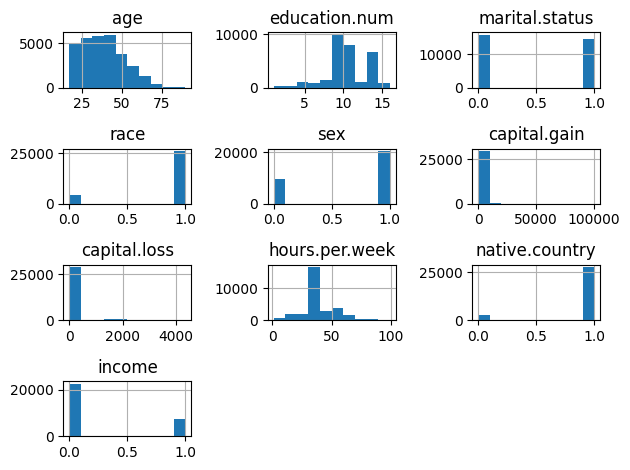

In [38]:
# what does the data look like now?
plt.figure(figsize=(50,50))

print(dataset_orig_clean['income'].value_counts())

# Plot the histogram of the dataset
dataset_orig_clean.hist()
plt.tight_layout()


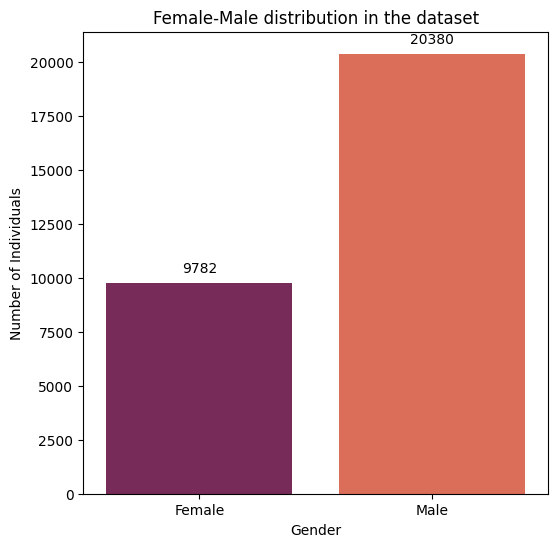

In [39]:
# Plot the graph using seaborn
plt.figure(figsize=(6,6))
ax = sns.countplot(data=dataset_orig_clean, x='sex', hue='sex', palette='rocket', legend=False)
plt.xlabel('Gender')
plt.ylabel('Number of Individuals')
plt.title('Female-Male distribution in the dataset')
plt.xticks([0, 1], labels=['Female', 'Male'], rotation=0)

# Add the exact number of bars on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

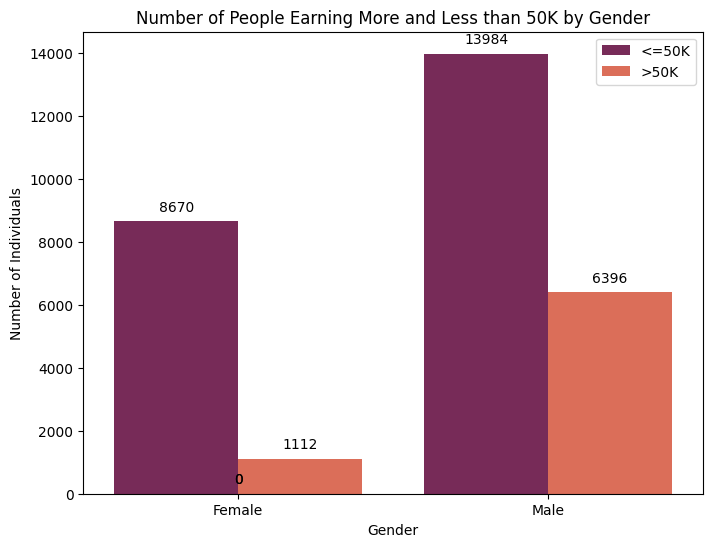

In [40]:
# Plot the graph using seaborn
plt.figure(figsize=(8,6))
ax = sns.countplot(data=dataset_orig_clean, x='sex', hue='income', palette='rocket')
plt.xlabel('Gender')
plt.ylabel('Number of Individuals')
plt.title('Number of People Earning More and Less than 50K by Gender')
plt.xticks([0, 1], labels=['Female', 'Male'], rotation=0)
plt.legend(['<=50K', '>50K'])


# Add the exact number of bars on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [41]:
# Count the number of people earning more and less than 50K, divided by gender
income_gender_counts = dataset_orig_clean.groupby(['sex', 'income']).size().unstack()
# if there are less female (sex=0) than male (x=1) earn >50K, female is the unprivileged group
if (income_gender_counts.loc[0][1] < income_gender_counts.loc[1][1]):
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
else:
    privileged_groups = [{'sex': 0}]
    unprivileged_groups = [{'sex': 1}]

In [42]:
binary_dataset = BinaryLabelDataset(
    df=dataset_orig_clean.copy(),
    label_names=['income'],
    favorable_label=1,
    unfavorable_label=0,
    protected_attribute_names=[sensible_attribute])

### Split into train and test

In [43]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_test = binary_dataset.split([0.7], shuffle=True)

In [44]:
df_train = dataset_orig_train.convert_to_dataframe()[0]
df_test = dataset_orig_test.convert_to_dataframe()[0]

In [45]:
# Count the number of people earning more and less than 50K, divided by gender for the training and testing datasets
income_gender_counts_train = df_train.groupby(['sex', 'income']).size().unstack()
income_gender_counts_test = df_test.groupby(['sex', 'income']).size().unstack()

# Normalize the counts by the total number of individuals in each set
train_size = df_train.shape[0]
test_size = df_test.shape[0]

print('Training set:', train_size, 'Testing set:', test_size)

Training set: 21113 Testing set: 9049


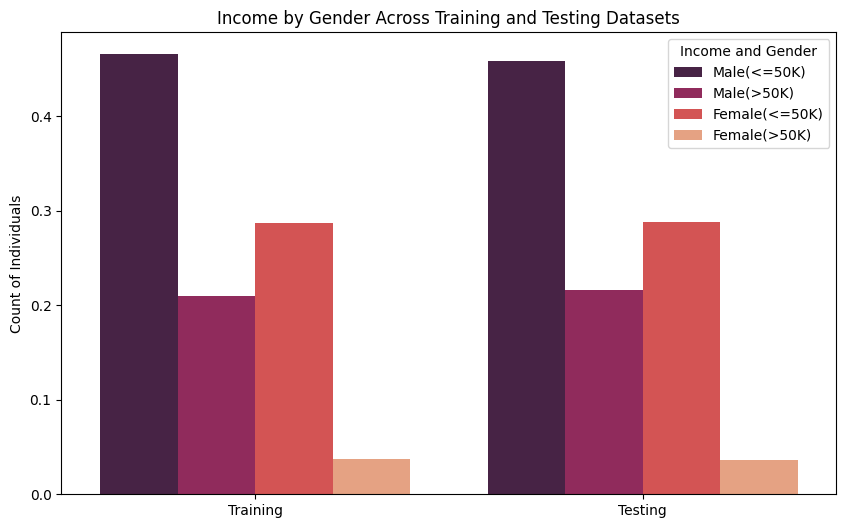

In [46]:
# Create a DataFrame for comparison
df_comparison_train_test = pd.DataFrame({
    'Male(<=50K)': [income_gender_counts_train.loc[1, 0]/train_size, income_gender_counts_test.loc[1, 0]/test_size],
    'Male(>50K)': [income_gender_counts_train.loc[1, 1]/train_size, income_gender_counts_test.loc[1, 1]/test_size],
    'Female(<=50K)': [income_gender_counts_train.loc[0, 0]/train_size, income_gender_counts_test.loc[0, 0]/test_size],
    'Female(>50K)': [income_gender_counts_train.loc[0, 1]/train_size, income_gender_counts_test.loc[0, 1]/test_size],
}, index=['Training', 'Testing'])

# Resetting the DataFrame for Seaborn
df_comparison_train_test_reset = df_comparison_train_test.reset_index().melt(id_vars='index', var_name='Gender_Income', value_name='Count')
df_comparison_train_test_reset.rename(columns={'index': 'Dataset_Type'}, inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comparison_train_test_reset, x='Dataset_Type', y='Count', hue='Gender_Income', palette='rocket')
plt.title("Income by Gender Across Training and Testing Datasets")
plt.xlabel("")
plt.ylabel("Count of Individuals")
plt.xticks(rotation=0)
plt.legend(title="Income and Gender")

plt.show()

In [47]:
display(Markdown("#### Training & Test dimensions"))
print(dataset_orig_train.features.shape[0],",", dataset_orig_test.features.shape[0])

#### Training & Test dimensions

21113 , 9049


#### Display properties of the training dataset

In [48]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(21113, 9)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education.num', 'marital.status', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']


In [49]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Statistical Parity Difference or Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Statistical Parity Difference or Difference in mean outcomes between unprivileged and privileged groups = -0.196578


### Train classifier on original data

In [50]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

In [51]:
if model == "Decision Tree":
    model_instance = DecisionTreeClassifier(max_features=14,min_samples_leaf=100,random_state=10)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)
elif model == "Logistic Regression":
    model_instance = LogisticRegression(random_state=101)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)
elif model == "Random Forest":
    model_instance = RandomForestClassifier(n_estimators=100, random_state=10)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)
elif model == "KNN":
    model_instance = KNeighborsClassifier(n_neighbors=3)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)



# positive class index
pos_ind = np.where(model_instance.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred


In [52]:
df_train_pred = dataset_orig_train_pred.copy(deepcopy=True)
df_train_pred.labels = df_train_pred.labels.reshape(-1, 1)
df_train_pred = df_train_pred.convert_to_dataframe()[0]


# above_50k_graph_df(df_train_pred)


In [53]:
print("Train accuracy:", round(accuracy_score(dataset_orig_train.labels, dataset_orig_train_pred.labels), 4))

Train accuracy: 0.8358


### Obtain scores for test set and find the optimal parameters from the test set

In [54]:
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
# y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = model_instance.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

#### Best threshold for classification only (no fairness)

if one label is more common than the other label, then the dataset is imbalanced -> balanced accuracy

0.5*(classified_metric_orig_test.true_positive_rate() + classified_metric_orig_test.true_negative_rate())

In [55]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > class_thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                             dataset_orig_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = balanced_accuracy_score(dataset_orig_test.labels, dataset_orig_test_pred.labels)

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))

print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.8127
Optimal classification threshold (no fairness constraints) = 0.2179


### Post-procesing technique

#### Estimate optimal parameters for the ROC method

In [56]:
# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

In [57]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.1, high_class_thresh=0.9,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_test, dataset_orig_test_pred)

In [58]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.1970
Optimal ROC margin = 0.1286


In [59]:
# Metrics for the test set
# if the probability of the positive class is greater than or equal to best_class_thresh, the sample will be classified as positive
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_cl_test_bef = compute_cl_metrics(dataset_orig_test, dataset_orig_test_pred)
metric_fn_test_bef = compute_fn_metrics(dataset_orig_test, dataset_orig_test_pred, unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy = 0.7861
Recall = 0.8668
Precision = 0.5488
Balanced accuracy = 0.8127
F1 = 0.6721
Statistical parity difference = -0.3898
Average odds difference = -0.2409
Equal opportunity difference = -0.1948


#### Predictions from Test Set

In [60]:
df_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0]

<Figure size 300x300 with 0 Axes>

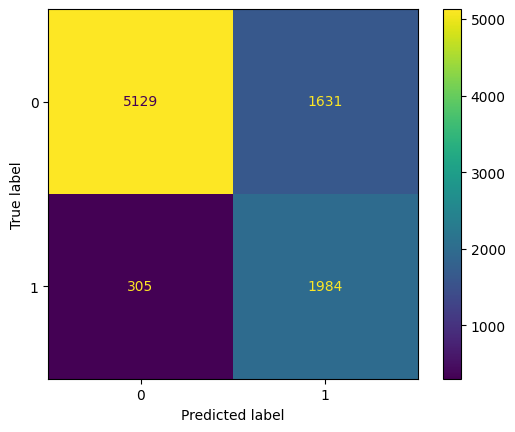

In [61]:
cm_test = conf_matrix(dataset_orig_test, dataset_orig_test_pred)

TP_discr = cm_test[1][1]
TN_discr = cm_test[0][0]
FN_discr = cm_test[1][0]
FP_discr = cm_test[0][1]

In [62]:
# above_50k_graph(dataset_orig_test_pred)

#### ROC prediction

In [63]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_cl_test_aft = compute_cl_metrics(dataset_orig_test, dataset_transf_test_pred)
metric_fn_test_aft = compute_fn_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Accuracy = 0.7689
Recall = 0.7851
Precision = 0.5292
Balanced accuracy = 0.7743
F1 = 0.6322
Statistical parity difference = -0.0482
Average odds difference = 0.1007
Equal opportunity difference = 0.1449


In [64]:
df_test_transf_pred = dataset_transf_test_pred.convert_to_dataframe()[0]

In [65]:
# conf_matrix(dataset_orig_test, dataset_transf_test_pred)
# above_50k_graph(dataset_transf_test_pred)

In [66]:
# Count the number of people earning more and less than 50K, divided by gender for the original test dataset, predicted test dataset and predicted after pp
income_gender_counts_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_transf_test_pred = dataset_transf_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()

df_comparison = pd.DataFrame({
    'Male(<=50K)': [income_gender_counts_test.loc[1, 0], income_gender_counts_test_pred.loc[1, 0], income_gender_counts_transf_test_pred.loc[1,0]],
    'Male(>50K)': [income_gender_counts_test.loc[1, 1], income_gender_counts_test_pred.loc[1, 1], income_gender_counts_transf_test_pred.loc[1,1]],
    'Female(<=50K)': [income_gender_counts_test.loc[0, 0], income_gender_counts_test_pred.loc[0, 0], income_gender_counts_transf_test_pred.loc[0,0]],
    'Female(>50K)': [income_gender_counts_test.loc[0, 1], income_gender_counts_test_pred.loc[0, 1], income_gender_counts_transf_test_pred.loc[0,1]],
})

df_comparison.index = ['Original', 'Predicted', 'Transformed']
df_comparison


,Male(<=50K),Male(>50K),Female(<=50K),Female(>50K)
Original,4149,1959,2611,330
Predicted,2894,3214,2540,401
Transformed,3720,2388,1933,1008


#### Accuracy 
Accuracy = 1 - (number of data units in error)/Total number of Not null data units

In [67]:
man_accuracy = round(
    (1 - abs(income_gender_counts_transf_test_pred.loc[1, 1] - income_gender_counts_test.loc[1, 1]) / total_test_len), 3)
female_accuracy = round(
    (1 - abs(income_gender_counts_transf_test_pred.loc[0, 0] - income_gender_counts_test.loc[0, 0]) / total_test_len), 3)

accuracy = {
    "Man": [man_accuracy],
    "Female": [female_accuracy]
}
df_accuracy = pd.DataFrame(accuracy, index=["Accuracy"])
df_accuracy


NameError: name 'total_test_len' is not defined

In [ ]:
# Calculate the initial tables
income_gender_counts_test = dataset_orig_test.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_transf_test_pred = dataset_transf_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()

total_test_len = df_test.shape[0]

# Create the initial comparison DataFrame
df_comparison_transf = pd.DataFrame({
    '% male(<=50K)': [(income_gender_counts_transf_test_pred.loc[1,0] / total_test_len) *100],
    '% male(>50K)': [(income_gender_counts_transf_test_pred.loc[1,1] / total_test_len) *100],
    '% female(<=50K)': [(income_gender_counts_transf_test_pred.loc[0,0] / total_test_len) *100],
    '% female(>50K)': [(income_gender_counts_transf_test_pred.loc[0,1] / total_test_len) *100]
}).map(lambda x: f"{x:.2f}%")

df_comparison_transf.index = [model]
df_comparison_transf

In [ ]:
# Calculate the initial tables
income_gender_counts_test = dataset_orig_test.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_transf_test_pred = dataset_transf_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()


# Create the initial comparison DataFrame
df_comparison_transf = pd.DataFrame({
    # ((male<=50(transf)-male<=50(orig)) / male<=50(orig))) *100
    'Δ male(<=50K)': [(income_gender_counts_transf_test_pred.loc[1,0]-income_gender_counts_test.loc[1, 0])],
    'Δ male(>50K)': [(income_gender_counts_transf_test_pred.loc[1,1]-income_gender_counts_test.loc[1, 1]) ],
    'Δ female(<=50K)': [(income_gender_counts_transf_test_pred.loc[0,0]-income_gender_counts_test.loc[0, 0]) ],
    'Δ female(>50K)': [(income_gender_counts_transf_test_pred.loc[0,1]-income_gender_counts_test.loc[0, 1])]
})

df_comparison_transf.index = [model]
df_comparison_transf


In [ ]:
# Resetting the DataFrame for Seaborn
df_comparison_reset = df_comparison[['Male(<=50K)', 'Male(>50K)', 'Female(<=50K)', 'Female(>50K)']].reset_index().melt(id_vars='index', var_name='Gender_Income', value_name='Count')
df_comparison_reset.rename(columns={'index': 'Dataset_Type'}, inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comparison_reset, x='Dataset_Type', y='Count', hue='Gender_Income', palette='rocket')
plt.title("Income by Gender Across Original, Predicted, and Transformed Datasets")
plt.xlabel("Dataset Type")
plt.ylabel("Count of Individuals")
plt.xticks(rotation=0)
plt.legend(title="Income and Gender")

plt.show()

### Evaluation Metrics For Classification Model and Fairness

In [ ]:
plot_metrics(metric_cl_test_bef, metric_cl_test_aft)

In [ ]:
df_cl_metrics = pd.DataFrame({
    'Metric': list(metric_cl_test_bef.keys()),
    'Before': [round(val, 3) for val in metric_cl_test_bef.values()],
    'After': [round(val, 3) for val in metric_cl_test_aft.values()]
})

# Calculate the percentage change
df_cl_metrics['Delta'] = (abs(df_cl_metrics['Before']) - abs(df_cl_metrics['After'])).apply(lambda x: f"{x:.3f}")
df_cl_metrics

In [ ]:
round(abs(metric_cl_test_bef['Accuracy'])-abs(metric_cl_test_aft['Accuracy']), 3)

In [ ]:
plot_fn_metrics(metric_fn_test_bef, metric_fn_test_aft, metric_name)

In [ ]:
df_metrics = pd.DataFrame({
    'Metric': list(metric_fn_test_bef.keys()),
    'Before': [round(val, 3) for val in metric_fn_test_bef.values()],
    'After': [round(val, 3) for val in metric_fn_test_aft.values()]
})

# Calculate the percentage change
df_metrics['Delta'] = (df_metrics['After'] - df_metrics['Before']).apply(lambda x: f"{x:.3f}")
df_metrics

In [ ]:
def get_test_groups(df_test, unprivileged_groups, privileged_groups):
    test_discriminated = df_test.loc[df_test['sex'] == unprivileged_groups[0]['sex']]
    test_privileged = df_test.loc[df_test['sex'] == privileged_groups[0]['sex']]
    print(len(test_privileged), len(test_discriminated))
    y_test_discriminated = test_discriminated['income'].astype(int)
    y_test_privileged = test_privileged['income'].astype(int)
    return y_test_privileged, y_test_discriminated

In [ ]:
y_test_privileged, y_test_discriminated = get_test_groups(df_test, unprivileged_groups, privileged_groups)
y_test_pred_privileged, y_test_pred_discriminated = get_test_groups(df_test_pred, unprivileged_groups, privileged_groups)
y_test_transf_pred_privileged, y_test_transf_pred_discriminated = get_test_groups(df_test_transf_pred, unprivileged_groups, privileged_groups)

In [ ]:
assert(len(y_test_privileged) == len(y_test_pred_privileged) == len(y_test_transf_pred_privileged))
assert(len(y_test_discriminated) == len(y_test_pred_discriminated) == len(y_test_transf_pred_discriminated))

In [ ]:

def calculate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    TP = cm[1][1]
    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]
    total = TP + TN + FN + FP
    
    return TP, TN, FN, FP, total

#### Fairness metrics before applying post-processing

#### Fairness metrics after applying post-processing

In [ ]:
TP_discr, TN_discr, FN_discr, FP_discr, len_priv = calculate_confusion_matrix(y_test_discriminated, y_test_pred_discriminated)
TP_priv, TN_priv, FN_priv, FP_priv, len_discr = calculate_confusion_matrix(y_test_privileged, y_test_pred_privileged)
TP_discr_pp, TN_discr_pp, FN_discr_pp, FP_discr_pp, len_discr_pp = calculate_confusion_matrix(y_test_discriminated, y_test_transf_pred_discriminated)
TP_priv_pp, TN_priv_pp, FN_priv_pp, FP_priv_pp, len_priv_pp = calculate_confusion_matrix(y_test_privileged, y_test_transf_pred_privileged)

In [ ]:
# Retrieve TP, TN, FP, FN values from a confusion matrix
def retrieve_values(cm):
  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]
  total = TN+FP+FN+TP
  return TP, TN, FP, FN, total

def rescale(metric):
  metric = metric - 1
  return metric

def standardization(metric):
  if metric > 1:
    metric = 1
  elif metric < -1:
    metric = -1
  return metric

def valid(metric, th):
  if metric > 1-th and metric < 1+th:
    return True
  return False

def and_function(m1, m2, th):
  if m1 > 1+th and m2 > 1+th:
    return max(m1, m2)
  elif m1 < 1-th and m2 < 1-th:
    return min(m1, m2)
  elif valid(m1, th) and valid(m2, th):
    return max(m1, m2)
  elif (valid(m1, th) or valid(m2, th)) and (m1 > 1+th or m2 > 1+th):
    return max(m1, m2)
  elif (valid(m1, th) or valid(m2, th)) and (m1 < 1-th or m2 < 1-th):
    return min(m1, m2)
  else:
    return max(m1, m2)

# Fairness metrics computed using division operator
def fairness_metrics_division(TP_discr, TN_discr, FP_discr, FN_discr, len_discr, TP_priv, TN_priv, FP_priv, FN_priv, len_priv, threshold = 0.15):

  # TP_priv, TN_priv, FP_priv, FN_priv, len_priv = retrieve_values(confusion_matrix['privileged'])
  # TP_discr, TN_discr, FP_discr, FN_discr, len_discr = retrieve_values(confusion_matrix['discriminated'])

  GroupFairness_discr = (TP_discr+FP_discr)/len_discr
  GroupFairness_priv = (TP_priv+FP_priv)/len_priv
  if GroupFairness_priv == 0:
    GroupFairness = 2  #max value
  else:
     GroupFairness = GroupFairness_discr/GroupFairness_priv

  if TP_discr+FP_discr == 0:
    PredictiveParity_discr = 0
    PredictiveParity = 0  #min value
  else:
    PredictiveParity_discr = (TP_discr)/(TP_discr+FP_discr)
  if TP_priv+FP_priv == 0:
    PredictiveParity_priv = 0
    PredictiveParity = 2  #max value
  else:
    PredictiveParity_priv = (TP_priv)/(TP_priv+FP_priv)
  if PredictiveParity_discr != 0 and PredictiveParity_priv != 0:
    PredictiveParity = PredictiveParity_discr/PredictiveParity_priv
  elif PredictiveParity_priv == 0:
    PredictiveParity = 2  #max value
  else:
    PredictiveParity = 0  #min value

  if TN_discr+FP_discr == 0:
    PredictiveEquality_discr = 0
    PredictiveEquality = 0  #min value
  else:
    PredictiveEquality_discr = (FP_discr)/(TN_discr+FP_discr)
  if TN_priv+FP_priv == 0:
    PredictiveEquality_priv = 0
    PredictiveEquality = 2  #max value
  else:
    PredictiveEquality_priv = (FP_priv)/(TN_priv+FP_priv)
  if PredictiveEquality_discr != 0 and PredictiveEquality_priv != 0:
    PredictiveEquality = PredictiveEquality_discr/PredictiveEquality_priv
  elif PredictiveEquality_priv == 0:
    PredictiveEquality = 2  #max value
  else:
    PredictiveEquality = 0  #min value

  if FN_priv+TP_priv == 0:
    EqualOpportunity_priv = 0
    EqualOpportunity = 2  #max value
  else:
    EqualOpportunity_priv = (FN_priv)/(TP_priv+FN_priv)
  if FN_discr+TP_discr == 0:
    EqualOpportunity_discr = 0
    EqualOpportunity = 0  #min value
  else:
    EqualOpportunity_discr = (FN_discr)/(TP_discr+FN_discr)
  if EqualOpportunity_priv != 0 and EqualOpportunity_discr != 0:
    EqualOpportunity = EqualOpportunity_priv/EqualOpportunity_discr
  elif EqualOpportunity_discr == 0:
    EqualOpportunity = 0  #min value
  else:
    EqualOpportunity = 2  #max value

  if FN_discr+TP_discr == 0:
    EqualizedOdds1 = 0
    EqualizedOdds = 0 #min value
  elif FN_priv+TP_priv == 0:
    EqualizedOdds1 = 0
    EqualizedOdds = 2 #max value
  elif (TP_priv/(TP_priv+FN_priv)) == 0:
    EqualizedOdds1 = 2 #max value
  else:
    EqualizedOdds1 = ((TP_discr/(TP_discr+FN_discr)) / (TP_priv/(TP_priv+FN_priv))) # (1-equalOpportunity_discr)/(1-equalOpportunity_priv)
  if TN_priv+FP_priv == 0:
    EqualizedOdds2 = 0
    EqualizedOdds = 2 #max value
  elif TN_discr+FP_discr == 0:
    EqualizedOdds2 = 0
    EqualizedOdds = 0 #min value
  elif (FP_priv/(TN_priv+FP_priv)) == 0:
    EqualizedOdds2 = 2 #max value
  else:
    EqualizedOdds2 = ((FP_discr/(TN_discr+FP_discr)) / (FP_priv/(TN_priv+FP_priv))) # = PredictiveEquality
  # EqualizedOdds = (EqualizedOdds1 * EqualizedOdds2)
  if EqualizedOdds1 != 0 and EqualizedOdds2 != 0:
    EqualizedOdds = and_function(EqualizedOdds1, EqualizedOdds2, threshold)
  else:
    EqualizedOdds = 2 #max value

  if TP_discr+FP_discr == 0 or TN_discr+FP_discr == 0:
    ConditionalUseAccuracyEquality1 = 0
    ConditionalUseAccuracyEquality= 0 #min value
  elif (TP_priv/(TP_priv+FP_priv)) == 0:
    ConditionalUseAccuracyEquality1 = 2 #max value
  else:
    ConditionalUseAccuracyEquality1 = ((TP_discr/(TP_discr+FP_discr)) / (TP_priv/(TP_priv+FP_priv)))
  if TN_discr+FN_discr == 0 or TN_priv+FN_priv == 0:
    ConditionalUseAccuracyEquality2 = 0
    ConditionalUseAccuracyEquality = 2 #max value
  elif (TN_priv/(TN_priv+FN_priv)) == 0:
    ConditionalUseAccuracyEquality2 = 2 #max value
  else:
    ConditionalUseAccuracyEquality2 = ((TN_discr/(TN_discr+FN_discr)) / (TN_priv/(TN_priv+FN_priv)))
  # ConditionalUseAccuracyEquality = (ConditionalUseAccuracyEquality1 * ConditionalUseAccuracyEquality2)
  if ConditionalUseAccuracyEquality1 != 0 and ConditionalUseAccuracyEquality2 != 0:
    ConditionalUseAccuracyEquality = and_function(ConditionalUseAccuracyEquality1, ConditionalUseAccuracyEquality2, threshold)
  else:
    ConditionalUseAccuracyEquality = 2 #max value

  if TP_priv == 0:
    OAE1 = 0
    OverallAccuracyEquality = 2 #max value
  else:
    OAE1 = TP_discr/TP_priv
  if TN_priv == 0:
    OAE2 = 0
    OverallAccuracyEquality = 2 #max value
  else:
    OAE2 = TN_discr/TN_priv
  # OverallAccuracyEquality = (OAE1 * OAE2)
  if OAE1 != 0 and OAE2 != 0:
    OverallAccuracyEquality = and_function(OAE1, OAE2, threshold)
  else:
    OverallAccuracyEquality = 2 #max value

  if FP_priv == 0:
    TreatmentEquality_priv = 0
    TreatmentEquality = 2  #max value
  else:
    TreatmentEquality_priv = (FN_priv/FP_priv)
  if FP_discr == 0:
    TreatmentEquality_discr = 0
    TreatmentEquality = 0 #min value
  elif (FN_discr/FP_discr) == 0:
    TreatmentEquality_discr = 0 #max value
    TreatmentEquality = 0 #min value
  else:
    TreatmentEquality_discr = (FN_discr/FP_discr)
  if TreatmentEquality_priv != 0 and TreatmentEquality_discr != 0:
    TreatmentEquality = TreatmentEquality_priv/TreatmentEquality_discr
  elif TreatmentEquality_priv == 0:
    TreatmentEquality = 2 #max value
  else:
    TreatmentEquality = 0 #min value

  if TN_priv+FN_priv == 0:
    FORParity_priv = 0
    FORParity = 2 #max value
  else:
    FORParity_priv = (FN_priv)/(TN_priv+FN_priv)
  if TN_discr+FN_discr == 0:
    FORParity_discr = 0
    FORParity = 0  #min value
  elif (FN_discr)/(TN_discr+FN_discr) == 0:
    FORParity_discr = 0
    FORParity = 0 #min value
  else:
    FORParity_discr = (FN_discr)/(TN_discr+FN_discr)
  if FORParity_priv != 0 and FORParity_discr != 0:
    FORParity = FORParity_priv/FORParity_discr
  elif FORParity_priv == 0:
    FORParity = 2 #max value
  else:
    FORParity = 0 #min value


  FN_P_discr = (FN_discr)/len_discr
  FN_P_priv = (FN_priv)/len_priv
  if FN_P_discr == 0:
    FN_metric = 2  #max value
  else:
    FN_metric = FN_P_priv/FN_P_discr


  FP_P_discr = (FP_discr)/len_discr
  FP_P_priv = (FP_priv)/len_priv
  if FP_P_priv == 0:
    FP_metric = 0  #min value
  else:
    FP_metric = FP_P_discr/FP_P_priv


  #RecallParity = (TP_discr/(TP_discr+FN_discr))/(TP_priv/(TP_priv+FN_priv))

  metrics = {}
  metrics['GroupFairness'] = [GroupFairness, GroupFairness_discr, GroupFairness_priv]
  metrics['PredictiveParity'] = [PredictiveParity, PredictiveParity_discr, PredictiveParity_priv]
  metrics['PredictiveEquality'] = [PredictiveEquality, PredictiveEquality_discr, PredictiveEquality_priv]
  metrics['EqualOpportunity'] = [EqualOpportunity, EqualOpportunity_discr, EqualOpportunity_priv]
  metrics['EqualizedOdds'] = [EqualizedOdds, EqualizedOdds1, EqualizedOdds2]
  metrics['ConditionalUseAccuracyEquality'] = [ConditionalUseAccuracyEquality, ConditionalUseAccuracyEquality1 , ConditionalUseAccuracyEquality2]
  metrics['OverallAccuracyEquality'] = [OverallAccuracyEquality, OAE1, OAE2]
  metrics['TreatmentEquality'] = [TreatmentEquality, TreatmentEquality_discr, TreatmentEquality_priv]
  metrics['FORParity'] = [FORParity, FORParity_discr, FORParity_priv]
  metrics['FN'] = [FN_metric, FN_P_discr, FN_P_priv]
  metrics['FP'] = [FP_metric, FP_P_discr, FP_P_priv]

  for k in metrics.keys():
    value = standardization(rescale(metrics[k][0]))
    discr = metrics[k][1]
    priv = metrics[k][2]
    metrics[k] = {'Value': value, 'Discr_group': discr, 'Priv_group': priv}

  return metrics


In [ ]:
fairness_metrics_n = fairness_metrics_division(TP_discr, TN_discr, FP_discr, FN_discr, len_discr, TP_priv, TN_priv, FP_priv, FN_priv, len_priv)
fairness_metrics_before_n = pd.DataFrame.from_dict(fairness_metrics_n, orient='index').reset_index()
fairness_metrics_before_n.columns = ['Metric', 'Value', 'Value_discriminated_group', 'Value_privileged_group']
fairness_metrics_before_n.head(len(fairness_metrics_before_n))

In [ ]:
fairness_metrics_pp_n = fairness_metrics_division(TP_discr_pp, TN_discr_pp, FP_discr_pp, FN_discr_pp, len_discr_pp, TP_priv_pp, TN_priv_pp, FP_priv_pp, FN_priv_pp, len_priv_pp)
fairness_metrics_after_n = pd.DataFrame.from_dict(fairness_metrics_pp_n, orient='index').reset_index()
fairness_metrics_after_n.columns = ['Metric', 'Value', 'Value_discriminated_group', 'Value_privileged_group']
fairness_metrics_after_n.head(len(fairness_metrics_before_n))

In [ ]:
# Combine the fairness metrics into a single DataFrame for comparison
df_fairness_comparison_n = pd.DataFrame({
    'Metric': fairness_metrics_before_n['Metric'],
    'Before': fairness_metrics_before_n['Value'],
    'After': fairness_metrics_after_n['Value']
})


# Plot the comparison
plt.figure(figsize=(14, 8))
df_fairness_comparison_melted = df_fairness_comparison_n.melt(id_vars='Metric', var_name='Stage', value_name='Value')
sns.barplot(data=df_fairness_comparison_melted, x='Metric', y='Value', hue='Stage', palette='viridis')
plt.title('Comparison of Fairness Metrics Before and After Applying ROC')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stage')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

df_fairness_comparison_n['Delta'] = (abs(df_fairness_comparison_n['Before']) - abs(df_fairness_comparison_n['After'])).apply(lambda x: f"{x:.3f}")

# Display the table
df_fairness_comparison_n

In [ ]:
# Combine all fairness metrics into a single DataFrame
all_fairness_metrics = pd.DataFrame({
    'Metric': fairness_metrics_before_n['Metric'],
    'Delta': (abs(fairness_metrics_before_n['Value']) - abs(fairness_metrics_after_n['Value'])).apply(lambda x: f"{x:.3f}")
})

all_fairness_metrics

In [ ]:
# Transpose the DataFrame to have metrics as columns and values in the first row
all_fairness_metrics_transposed = all_fairness_metrics.set_index('Metric').T
all_fairness_metrics_transposed.index = [model]
# Display the DataFrame
all_fairness_metrics_transposed

In [ ]:
# Filter the DataFrame to include only the desired metrics
metrics_to_plot = ['GroupFairness', 'EqualOpportunity', 'PredictiveParity']
df_filtered = df_fairness_comparison_melted[df_fairness_comparison_melted['Metric'].isin(metrics_to_plot)]

# Plot the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x='Stage', y='Value', hue='Metric', marker='o')
plt.title('Comparison of Selected Fairness Metrics Before and After Applying ROC')
plt.ylabel('Metric Value')
plt.xlabel('Stage')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.legend(title='Metric')
plt.show()

## Association rules

- Support: The proportion of transactions in the dataset where both antecedent and consequent are present.
    - Measures how frequently a rule is observed in the dataset.
- Confidence: The ratio of the number of times both antecedent and consequent occur together to the number of times the antecedent occurs.
    - Represents how often the rule is true.

**FP-GROWTH**

Compress a large database into a compact, Frequent-Pattern tree (FP-tree) structure.

Datasets are encoded using a compact structure, the FP-tree.

Frequent itemsets are extracted directly from the FP-tree.

***GOAL*** To avoid candidate generation (computationally expensive)

Main steps:

    1. Construct the frequent pattern tree
    2. For each frequent item: compute the projected FP-tree
    3. Mine conditional FP-trees and grow frequent patterns
    4. If the conditional FP-tree contains a single path: enumerate all the patterns


In [ ]:
def prepare_dataset_asso_rules(dataset_to_prepare): 
    # Convert the dataset to a DataFrame
    if not isinstance(dataset_to_prepare, pd.DataFrame):
        pd_converted = dataset_to_prepare.convert_to_dataframe()[0]
    else:
        pd_converted = dataset_to_prepare

    # Education number from 0 to 5 are put in '<6' and those above 13 into '>12'
    pd_converted['education.num'] = pd_converted['education.num'].apply(lambda x: group_edu(x))
    pd_converted['education.num'] = pd_converted['education.num'].astype(str)
    # Group age by decade
    pd_converted['Age (decade)'] = pd_converted['age'].apply(lambda x: x//10*10)
    pd_converted = pd_converted.drop(columns='age')
    # Group hours per week
    pd_converted['hours.per.week'] = pd_converted['hours.per.week'].apply(lambda x: '>40' if x > 40 else '<=40')

    # Capital gain is splitted into two columns capital.gain>0 and capital.gain=0
    pd_converted['capital.gain>0'] = pd_converted['capital.gain'].apply(lambda x: 1 if x > 0 else 0)
    pd_converted['capital.gain=0'] = pd_converted['capital.gain'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='capital.gain', inplace=True)

    # Capital loss is splitted into two columns capital.loss>0 and capital.loss=0
    pd_converted['capital.loss>0'] = pd_converted['capital.loss'].apply(lambda x: 1 if x > 0 else 0)
    pd_converted['capital.loss=0'] = pd_converted['capital.loss'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='capital.loss', inplace=True)


    pd_converted['male'] = pd_converted['sex'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['female'] = pd_converted['sex'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='sex', inplace=True) 

    # Process 'race' column
    pd_converted['white'] = pd_converted['race'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['n_white'] = pd_converted['race'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='race', inplace=True)

    # Process 'income' column
    pd_converted['>50K'] = pd_converted['income'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['<50K'] = pd_converted['income'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='income', inplace=True)

    # 1 if married, 0 otherwise
    pd_converted['married'] = pd_converted['marital.status'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['n_married'] = pd_converted['marital.status'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='marital.status', inplace=True)

    # United-States is 1 all the target_variable = 'income' = 'income'er countries are 0
    pd_converted['UnitedStates'] = pd_converted['native.country'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['n_UnitedStates'] = pd_converted['native.country'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='native.country', inplace=True)
    
    pd_converted.drop(columns=['capital.loss>0', 'capital.loss=0', 'capital.gain>0', 'capital.gain=0'], inplace=True)
    pd_converted.drop(columns=['hours.per.week'], inplace=True)

    return pd_converted

In [ ]:
 
def compute_income_rules(dataset, min_support, min_confidence):
    data_asso_rules = prepare_dataset_asso_rules(dataset)
    data_asso_rules = pd.get_dummies(data_asso_rules,columns=['education.num','Age (decade)'],drop_first=False)

    # Create a binary representation of transactions
    df_transactions = data_asso_rules.map(lambda x: True if x > 0 else False)

    # Apply FP-growth algorithm to find frequent itemsets
    frequent_itemsets = fpgrowth(df_transactions, min_support=min_support, use_colnames=True)

    # Extract association rules with min confidence
    res = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    # res.to_csv('association_rules.csv')
    # Filter rules with consequents '<=50K' and '>50K'
    res_min50 = res[res['consequents'] == {'<50K'}]
    res_max50 = res[res['consequents'] == {'>50K'}]

    return res_min50, res_max50


In [ ]:
 
def compute_df_transactions(dataset):
    data_asso_rules = prepare_dataset_asso_rules(dataset)
    data_asso_rules = pd.get_dummies(data_asso_rules,columns=['education.num','Age (decade)'],drop_first=False)

    # Create a binary representation of transactions
    df_transactions = data_asso_rules.map(lambda x: True if x > 0 else False)
    return df_transactions


In [ ]:
res_min50_test, res_max50_bd = compute_income_rules(dataset_orig_test, user_min_support, user_min_confidence)

In [ ]:
# # quick check with apriori
# a_rules = apriori(df_transactions, min_support = 0.2, use_colnames = True)
# res_a = association_rules(a_rules, metric="confidence", min_threshold=0.5)
# res_a_min50 = res_a[res_a['consequents'] == {'<50K'}]
# res_a_min50.sort_values("confidence", ascending = False)
# res_a_min50.to_csv('association_rules_ap.csv')

In [ ]:
# 4 rules show up only with support > 0.1 and confidence > 0.5
res_max50_bd.sort_values("confidence", ascending=False)

In [ ]:
# res_min50_test.sort_values("confidence", ascending=False).to_csv('association_rules.csv')

### Test predicions rules matching

In [ ]:
df_transactions_test_pred = compute_df_transactions(dataset_orig_test)

In [ ]:
results_before_roc = []

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = df_transactions_test_pred.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching before pp': total_consequent_met,
        'Respecting the rule before pp': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",
    }
    
    results_before_roc.append(rule_result)

# Create a DataFrame to display the results
results_bf_roc_df = pd.DataFrame(results_before_roc)
display(results_bf_roc_df)

In [ ]:
def extract_and_convert_support_confidence(rules):
      """
      Extracts support and confidence from rules and returns a DataFrame.

      Parameters:
          rules (pd.DataFrame): A DataFrame containing 'antecedents', 'support', and 'confidence' columns.

      Returns:
          pd.DataFrame: A DataFrame with 'Antecedents', 'Support', and 'Confidence' columns.
      """
      # Step 1: Extract relevant columns and round values
      extracted_data = [
          {
              "Antecedents": rule["antecedents"],
              "Support": round(rule["support"], 3),
              "Confidence": round(rule["confidence"], 3)
          }
          for _, rule in rules.iterrows()
      ]

      # Step 2: Convert the list of dictionaries into a DataFrame
      df_support_confidence = pd.DataFrame(extracted_data)

      return df_support_confidence


In [ ]:
df_rulez = extract_and_convert_support_confidence(res_min50_test)
df_rulez

In [ ]:
  # Function to extract support and confidence for a given set of rules
def extract_support_confidence(rules):
    return {frozenset(rule['antecedents']): (round(rule['support'], 3), round(rule['confidence'], 3)) for _, rule in rules.iterrows()}

support_confidence_test = extract_support_confidence(res_min50_test)
support_confidence_test
df_support_confidence_test = pd.DataFrame(list(support_confidence_test.items()), columns=['Antecedents', 'Support_Confidence'])
df_support_confidence_test[['Support', 'Confidence']] = pd.DataFrame(df_support_confidence_test['Support_Confidence'].tolist(), index=df_support_confidence_test.index)
df_support_confidence_test.drop(columns=['Support_Confidence'], inplace=True)
df_support_confidence_test

### Post PP rules matching

In [ ]:
df_transactions_after_pp = compute_df_transactions(dataset_transf_test_pred)


In [ ]:
results_after_roc = []

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = df_transactions_after_pp.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching after pp': total_consequent_met,
        'Respecting the rule after pp': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",
    }
    
    results_after_roc.append(rule_result)

# Create a DataFrame to display the results
results_after_roc_df = pd.DataFrame(results_after_roc)
display(results_after_roc_df)



Comparison of  association rules in the predicted test datatset before/after post-processing

In [ ]:
results_df = results_bf_roc_df.copy()
results_df['Number of conseq matching after pp'] = results_after_roc_df['Number of conseq matching after pp']
results_df['Respecting the rule after pp'] = results_after_roc_df['Respecting the rule after pp']
results_df

In [ ]:
consistency_df = results_df.copy()
consistency_df = consistency_df[['Rule','Respecting the rule before pp', 'Respecting the rule after pp']]
consistency_df

In [ ]:
# Calculate association rules for the transformed test dataset
res_min50_transf, res_max50_transf = compute_income_rules(dataset_transf_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)
res_min50_test_pred, res_max50_test_pred = compute_income_rules(dataset_orig_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)

# Function to extract support and confidence for a given set of rules
def extract_support_confidence(rules):
    return {frozenset(rule['antecedents']): (round(rule['support'], 3), round(rule['confidence'], 3)) for _, rule in rules.iterrows()}

# Extract support and confidence for each set of rules
support_confidence_test = extract_support_confidence(res_min50_test)
support_confidence_test_pred = extract_support_confidence(res_min50_test_pred)
support_confidence_test_pred_pp = extract_support_confidence(res_min50_transf)

# Combine all rules
all_rules = set(support_confidence_test.keys()).union(support_confidence_test_pred.keys()).union(support_confidence_test_pred_pp.keys())

In [ ]:
# Initial MultiIndex
multiIndex_consistency = pd.MultiIndex.from_tuples(
    [('Origin','Rule'),('Origin', 'Support'), ('Origin', 'Confidence')],
    names=['Model', 'Metric']
)
df_consistency = pd.DataFrame(columns=multiIndex_consistency)


In [ ]:
support_confidence_test = extract_and_convert_support_confidence(res_min50_test)
support_confidence_test

In [ ]:
support_confidence_test_pred_pp = extract_and_convert_support_confidence(res_min50_transf)
support_confidence_test_pred_pp

In [ ]:
# Reindex support_confidence_test_pred_pp to match the index of df_consistency
support_confidence_test_pred_pp_reindexed = support_confidence_test_pred_pp.reindex(df_consistency.index)

df_consistency[(model, 'Support')] = support_confidence_test_pred_pp_reindexed['Support'].tolist()
df_consistency[(model, 'Confidence')] = support_confidence_test_pred_pp_reindexed['Confidence'].tolist()
    

In [ ]:
# Calculate consistency

# Extract all tuples where the post-processing changed the output
changed_tuples = dataset_orig_test_pred.labels != dataset_transf_test_pred.labels
changed_df = dataset_transf_test_pred.convert_to_dataframe()[0][changed_tuples]
consistency_transactions= compute_df_transactions(changed_df)
# checking if the label-changed tuples are respecting the association rules
consistency_list = []
total_changed_tuples = consistency_transactions.shape[0]

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = consistency_transactions.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%"
    }
    consistency_list.append(rule_result)
    


In [ ]:
df_consistency[(model, 'Consistency')] = consistency_list

In [ ]:
data = []
for rule in support_confidence_test:
    rule_str = ', '.join(rule)
    test_support_confidence = support_confidence_test.get(rule, (None, None))
    
    test_pred_pp_support_confidence = support_confidence_test_pred_pp.get(rule, (None, None))
    
    data.append([
        rule_str,
        test_support_confidence[0], test_support_confidence[1],
        test_pred_pp_support_confidence[0], test_pred_pp_support_confidence[1]
    ])

In [ ]:
## model            Origin                                   M1                         M2
## metric  Support Confidence Consistency   Support Confidence Consistency  Support Confidence Consistency

# Combine all rules data into a list
data = []
for rule in all_rules:
    rule_str = ', '.join(rule)
    test_support_confidence = support_confidence_test.get(rule, (None, None))
    
    test_pred_pp_support_confidence = support_confidence_test_pred_pp.get(rule, (None, None))
    
    data.append([
        rule_str,
        test_support_confidence[0], test_support_confidence[1],
        test_pred_pp_support_confidence[0], test_pred_pp_support_confidence[1]
    ])

display(data)

# Define columns for the DataFrame
columns = ['Rule', 'Test Support', 'Test Confidence', 'Test Pred PP Support', 'Test Pred PP Confidence']

# Create DataFrame
df_combined = pd.DataFrame(data, columns=columns)

# Create a MultiIndex for the columns with two levels: Dataset and Metric
df_combined.set_index('Rule', inplace=True)

# Create tuples for the MultiIndex (Dataset, Metric)
multi_columns = pd.MultiIndex.from_tuples([
    ('Test', 'Support'), ('Test', 'Confidence'),
    ('Test Pred PP', 'Support'), ('Test Pred PP', 'Confidence')],
    names=['Dataset', 'Metric']
)

# Apply the MultiIndex to the columns
df_combined.columns = multi_columns

# Display the DataFrame
df_combined


In [ ]:
# Combine all rules data into a list
data = []
for rule in all_rules:
    rule_str = ', '.join(rule)
    test_support_confidence = support_confidence_test.get(rule, (None, None))
    test_pred_support_confidence = support_confidence_test_pred.get(rule, (None, None))
    test_pred_pp_support_confidence = support_confidence_test_pred_pp.get(rule, (None, None))
    
    data.append([
        rule_str,
        test_support_confidence[0], test_support_confidence[1],
        test_pred_support_confidence[0], test_pred_support_confidence[1],
        test_pred_pp_support_confidence[0], test_pred_pp_support_confidence[1]
    ])

# Define columns for the DataFrame
columns = ['Rule', 'Test Support', 'Test Confidence', 'Test Pred Support', 'Test Pred Confidence', 'Test Pred PP Support', 'Test Pred PP Confidence']

# Create DataFrame
df_combined = pd.DataFrame(data, columns=columns)

# Create a MultiIndex for the columns with two levels: Dataset and Metric
df_combined.set_index('Rule', inplace=True)

# Create tuples for the MultiIndex (Dataset, Metric)
multi_columns = pd.MultiIndex.from_tuples([
    ('Test', 'Support'), ('Test', 'Confidence'), 
    ('Test Pred', 'Support'), ('Test Pred', 'Confidence'), 
    ('Test Pred PP', 'Support'), ('Test Pred PP', 'Confidence')],
    names=['Dataset', 'Metric']
)

# Apply the MultiIndex to the columns
df_combined.columns = multi_columns

# Display the DataFrame
df_combined

In [ ]:
# Calculate association rules for the transformed test dataset
res_min50_transf, res_max50_transf = compute_income_rules(dataset_transf_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)
res_min50_test_pred, res_max50_test_pred = compute_income_rules(dataset_orig_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)


print("Comparing between test and test_pred\n")

# Function to calculate and return the number of rules kept, not kept, and newly introduced
def compare_rules(res_orig, res_transf, consequent):
    rules_kept = set(res_orig['antecedents']).intersection(set(res_transf['antecedents']))
    rules_not_kept = set(res_orig['antecedents']).difference(set(res_transf['antecedents']))
    new_rules = set(res_transf['antecedents']).difference(set(res_orig['antecedents']))


    print(f"Number of association rules with consequents '{consequent}' kept: {len(rules_kept)}")
    print(f"Number of association rules with consequents '{consequent}' not kept: {len(rules_not_kept)}")
    print(f"Number of new association rules with consequents '{consequent}': {len(new_rules)}")
    
    df_rules_kept = res_orig[res_orig['antecedents'].isin(rules_kept)]
    df_rules_not_kept = res_orig[res_orig['antecedents'].isin(rules_not_kept)]
    df_new_rules = res_transf[res_transf['antecedents'].isin(new_rules)]

    return df_rules_kept, df_rules_not_kept, df_new_rules

# Compare rules for '<=50K'
df_rules_kept, df_rules_not_kept, df_new_rules = compare_rules(res_min50_test, res_min50_test_pred, '<=50K')
# Display the dataframes
print("\nRules Kept:")
display(df_rules_kept[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))

print("\nRules Not Kept:")
display(df_rules_not_kept[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))

print("\nNew Rules:")
display(df_new_rules[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))


In [ ]:
print("Comparing between test and test_transf\n")

# Function to calculate and return the number of rules kept, not kept, and newly introduced
def compare_rules(res_orig, res_transf, consequent):
    rules_kept = set(res_orig['antecedents']).intersection(set(res_transf['antecedents']))
    rules_not_kept = set(res_orig['antecedents']).difference(set(res_transf['antecedents']))
    new_rules = set(res_transf['antecedents']).difference(set(res_orig['antecedents']))


    print(f"Number of association rules with consequents '{consequent}' kept: {len(rules_kept)}")
    print(f"Number of association rules with consequents '{consequent}' not kept: {len(rules_not_kept)}")
    print(f"Number of new association rules with consequents '{consequent}': {len(new_rules)}")
    
    df_rules_kept = res_orig[res_orig['antecedents'].isin(rules_kept)]
    df_rules_not_kept = res_orig[res_orig['antecedents'].isin(rules_not_kept)]
    df_new_rules = res_transf[res_transf['antecedents'].isin(new_rules)]

    return df_rules_kept, df_rules_not_kept, df_new_rules

# Compare rules for '<=50K'
df_rules_kept, df_rules_not_kept, df_new_rules = compare_rules(res_min50_test_pred, res_min50_transf, '<=50K')
# Display the dataframes
print("\nRules Kept:")
display(df_rules_kept[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))

print("\nRules Not Kept:")
display(df_rules_not_kept[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))

print("\nNew Rules:")
display(df_new_rules[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))


## Consistency
considering the modified output tuples, how many violetes the association rules.

In [ ]:
# Extract all tuples where the post-processing changed the output
changed_tuples = dataset_orig_test_pred.labels != dataset_transf_test_pred.labels
changed_df = dataset_transf_test_pred.convert_to_dataframe()[0][changed_tuples]
consistency_transactions= compute_df_transactions(changed_df)


In [ ]:
# checking if the label-changed tuples are respecting the association rules
consistency_df = []
total_changed_tuples = consistency_transactions.shape[0]
non_respect = 0
# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = consistency_transactions.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching after pp': total_consequent_met,
        'Respecting the rule after pp': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",   
    }
    consistency_df.append(rule_result)


# Create a DataFrame to display the results
results_after_roc_df = pd.DataFrame(consistency_df)
display(results_after_roc_df)


In [ ]:
support_confidence_test = extract_support_confidence(res_min50_transf)
df_support_confidence_test = pd.DataFrame(list(support_confidence_test.items()), columns=['Antecedents', 'Support_Confidence'])
df_support_confidence_test[['Support', 'Confidence']] = pd.DataFrame(df_support_confidence_test['Support_Confidence'].tolist(), index=df_support_confidence_test.index)
df_support_confidence_test.drop(columns=['Support_Confidence'], inplace=True)
df_support_confidence_test


In [ ]:
# Unire i due DataFrame sulla colonna 'Rule'
merged_df = results_after_roc_df.copy()

# Copia delle colonne 'Support' e 'Confidence' da df_support_confidence_test a merged_df
merged_df['Support'] = df_support_confidence_test['Support']
merged_df['Confidence'] = df_support_confidence_test['Confidence']

# Visualizzare il DataFrame risultante
display(merged_df)

In [ ]:
# Extract all tuples where the post-processing changed the output
changed_tuples = dataset_orig_test_pred.labels != dataset_transf_test_pred.labels
changed_df = dataset_transf_test_pred.convert_to_dataframe()[0][changed_tuples]
changed_df

In [ ]:
changed_transactions= compute_df_transactions(changed_df)
changed_transactions

In [ ]:
def satisfies_rule(row, antecedents, consequents):
    antecedent_check = all(row[item] for item in antecedents)
    consequent_check = all(row[item] for item in consequents)
    return not antecedent_check or ( antecedent_check and consequent_check)

# Step 3: Check rows in the modified DB that violate any of the rules
rows_not_respecting_rules = 0

def violates_any_rule(row, rules):
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        if not satisfies_rule(row, antecedents, consequents):
            return True  # Row violates this rule
    return False  # Row satisfies all rules

# Check for rows violating any rule in the modified DB

    
rows_violating_rules = changed_transactions.apply(lambda row: violates_any_rule(row, res_min50_test), axis=1)
rows_not_respecting_rules = rows_violating_rules.sum()

# Calculate the delta
total_rows = len(df_transactions_after_pp)
delta = 1 - (rows_not_respecting_rules / total_rows)

# Display results
print(f"Total rows in modified DB: {total_rows}")
print(f"Rows that no longer respect rules: {rows_not_respecting_rules}")
print(f"Delta: {delta:.4f}")
